In [1]:
"""
Import necessary packages
"""

# import os and set devices to only cpu
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# all other imports
from forgetting_mlp_utilities import *
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import sys

"""
Complete checks to ensure status of TensorFlow
"""

# ensure eager execution
print("Eager execution:", tf.executing_eagerly())

# check if GPU is available on system
device_name = tf.config.list_physical_devices("GPU")

if(device_name):
    print(f"GPU Available: {device_name}")
else:
    print("CPU Only")

2025-10-26 11:12:34.949393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761502354.989639  181614 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761502355.006597  181614 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Eager execution: True
CPU Only


2025-10-26 11:12:39.158322: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-10-26 11:12:39.158355: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: AGSTUF
2025-10-26 11:12:39.158363: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: AGSTUF
2025-10-26 11:12:39.158444: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 580.82.9
2025-10-26 11:12:39.158470: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 580.82.9
2025-10-26 11:12:39.158477: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 580.82.9


In [2]:
def run_experiment(depth = 2,
                   dropout_rate = 0.3,
                   loss_type = NLL,
                   optimizer_type = ADAM,
                   learning_rate = 0.001,
                   l1_lambda = 1e-5,
                   l2_lambda = 1e-4,
                   seed = 12345):
    
    # INITIALIZE THE EXPERIMENT
    
    # set the seed value for repetition
    set_seed(seed_in = seed)

    # download from the mnist dataset
    X_val, y_val, X_train, y_train, X_test, y_test = get_data(valid_fract = 0.10)

    # generate 10 different random permutations for the 10 tasks
    num_tasks = 10
    task_permutations = [np.random.permutation(784) for task in range(num_tasks)]

    # apply each permutation to create task-specific datasets
    task_datasets = []
    for task, perm in enumerate(task_permutations):
        X_train_task = X_train[:, perm]
        X_val_task   = X_val[:, perm]
        X_test_task  = X_test[:, perm]
        task_datasets.append((X_train_task, y_train, X_val_task, 
                            y_val, X_test_task, y_test))
        
    # initialize output
    acc_matrix = np.zeros((num_tasks, num_tasks))
    val_histories = []
        
    # BUILD THE MODEL

    # define the regularizer and the model
    reg = get_regularizer(loss_type, l1_lambda, l2_lambda)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(784,)))

    # add layers depending on the depth given
    for layer in range(depth):
            
            model.add(tf.keras.layers.Dense(256, activation="relu", 
                                            kernel_regularizer=reg))
            
            # apply dropout rate if greater than 0
            if dropout_rate > 0:
                model.add(tf.keras.layers.Dropout(dropout_rate))

    # add final output layer with 10 output nodes for classification
    model.add(tf.keras.layers.Dense(10, activation="softmax", 
                                        kernel_regularizer=reg))

    # compile the model with the correct optimizer and loss function
    model.compile(
            optimizer = get_optimizer(optimizer_type, learning_rate),
            loss = tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=["accuracy"])
    
    # RUN THE MODEL

    # define the epochs and batch size
    epochs_schedule = (50, 20, 20, 20, 20, 20, 20, 20, 20, 20)
    batch_size = 100

    # iterate through all 10 tasks
    for task_index, (X_train_task, y_train_task,
                     X_val_task, y_val_task,
                     X_test_task, y_test_task) in enumerate(task_datasets):

        # get the number of epochs for this task
        epochs_num = epochs_schedule[task_index]
    
        # display task number
        print(f"Training Task: {task_index + 1} / 10")

        # train the model on the current permuted dataset
        history = model.fit(
            X_train_task, y_train_task,
            validation_data = (X_val_task, y_val_task),
            batch_size = batch_size,
            epochs = epochs_num,
            verbose = 1)
        
        # save validation accuracy history
        val_histories.append(history.history["val_accuracy"])

        # EVALUATE MODEL
        for prev_task_index in range(task_index + 1):

            X_test_prev, y_test_prev = (
                task_datasets[prev_task_index][4],  # note: X_test_task
                task_datasets[prev_task_index][5]   # note: y_test_task
            )

            _, test_acc = model.evaluate(X_test_prev, y_test_prev, verbose = 0)
            acc_matrix[task_index, prev_task_index] = test_acc

    # after finishing all 10 tasks, compute ACC and BWT
    ACC, BWT, TBWT, CBWT = summarize_metrics(acc_matrix)

    print("\nExperiment Complete!")
    print(f"Final Average Accuracy (ACC): {ACC}")
    print(f"Backward Transfer (BWT): {BWT}")
    print(f"Task-wise BWT (TBWT): {TBWT}")        
    print(f"Cumulative BWT over time (CBWT): {CBWT}")

    return acc_matrix, ACC, BWT, TBWT, CBWT, val_histories
    

In [ ]:
# This will be used as the default values for testing

acc_matrix, ACC, BWT, TBWT, CBWT, val_histories = run_experiment(
    depth = 2,                
    dropout_rate = 0.3, 
    loss_type = NLL,
    optimizer_type = ADAM,
    learning_rate = 0.001,
    l1_lambda = 1e-5,
    l2_lambda = 1e-4,
    seed = 12345
)

Train Set:        (54000, 784), (54000,)
Validation Set:   (6000, 784) , (6000,)
Test Set:         (10000, 784), (10000,)
Training Task: 1 / 10
Epoch 1/50


2025-10-26 11:12:59.275069: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7885 - loss: 0.5918 - val_accuracy: 0.8532 - val_loss: 0.4085
Epoch 2/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8455 - loss: 0.4285 - val_accuracy: 0.8602 - val_loss: 0.3793
Epoch 3/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8567 - loss: 0.3910 - val_accuracy: 0.8822 - val_loss: 0.3299
Epoch 4/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8649 - loss: 0.3665 - val_accuracy: 0.8827 - val_loss: 0.3242
Epoch 5/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8703 - loss: 0.3504 - val_accuracy: 0.8885 - val_loss: 0.3072
Epoch 6/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8759 - loss: 0.3394 - val_accuracy: 0.8928 - val_loss: 0.2933
Epoch 7/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8784 - loss: 0.3278 - val_accuracy: 0.8915 - val_loss: 0.2944
Epoch 8/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8822 - loss: 0.3176 - val_accuracy: 0.8892 - val_

2025-10-26 11:14:41.684205: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7383 - loss: 0.7479 - val_accuracy: 0.8435 - val_loss: 0.4525
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8125 - loss: 0.5047 - val_accuracy: 0.8557 - val_loss: 0.4120
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8291 - loss: 0.4633 - val_accuracy: 0.8690 - val_loss: 0.3809
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8365 - loss: 0.4384 - val_accuracy: 0.8712 - val_loss: 0.3670
Epoch 5/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8427 - loss: 0.4199 - val_accuracy: 0.8775 - val_loss: 0.3555
Epoch 6/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8502 - loss: 0.4013 - val_accuracy: 0.8758 - val_loss: 0.3458
Epoch 7/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8535 - loss: 0.3928 - val_accuracy: 0.8780 - val_loss: 0.3380
Epoch 8/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8584 - loss: 0.3788 - val_accuracy: 0.8825 - val_

2025-10-26 11:15:20.093012: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7215 - loss: 0.7677 - val_accuracy: 0.8203 - val_loss: 0.5040
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8006 - loss: 0.5445 - val_accuracy: 0.8455 - val_loss: 0.4506
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8184 - loss: 0.4912 - val_accuracy: 0.8535 - val_loss: 0.4186
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8291 - loss: 0.4650 - val_accuracy: 0.8618 - val_loss: 0.4022
Epoch 5/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8361 - loss: 0.4426 - val_accuracy: 0.8647 - val_loss: 0.3927
Epoch 6/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8404 - loss: 0.4270 - val_accuracy: 0.8675 - val_loss: 0.3784
Epoch 7/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8431 - loss: 0.4181 - val_accuracy: 0.8657 - val_loss: 0.3761
Epoch 8/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8521 - loss: 0.4031 - val_accuracy: 0.8668 - val_

2025-10-26 11:16:00.923793: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7139 - loss: 0.7714 - val_accuracy: 0.8180 - val_loss: 0.5183
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7931 - loss: 0.5562 - val_accuracy: 0.8373 - val_loss: 0.4538
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8136 - loss: 0.5006 - val_accuracy: 0.8535 - val_loss: 0.4200
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8265 - loss: 0.4677 - val_accuracy: 0.8607 - val_loss: 0.3976
Epoch 5/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8346 - loss: 0.4463 - val_accuracy: 0.8667 - val_loss: 0.3867
Epoch 6/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8395 - loss: 0.4304 - val_accuracy: 0.8672 - val_loss: 0.3802
Epoch 7/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8465 - loss: 0.4138 - val_accuracy: 0.8740 - val_loss: 0.3602
Epoch 8/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8497 - loss: 0.4033 - val_accuracy: 0.8708 - val_

2025-10-26 11:16:40.980626: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7024 - loss: 0.8187 - val_accuracy: 0.8078 - val_loss: 0.5377
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7812 - loss: 0.5898 - val_accuracy: 0.8387 - val_loss: 0.4797
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7961 - loss: 0.5379 - val_accuracy: 0.8468 - val_loss: 0.4438
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8096 - loss: 0.5067 - val_accuracy: 0.8522 - val_loss: 0.4227
Epoch 5/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8203 - loss: 0.4781 - val_accuracy: 0.8627 - val_loss: 0.4001
Epoch 6/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8273 - loss: 0.4595 - val_accuracy: 0.8652 - val_loss: 0.3834
Epoch 7/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8334 - loss: 0.4464 - val_accuracy: 0.8670 - val_loss: 0.3871
Epoch 8/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8397 - loss: 0.4342 - val_accuracy: 0.8695 - val_

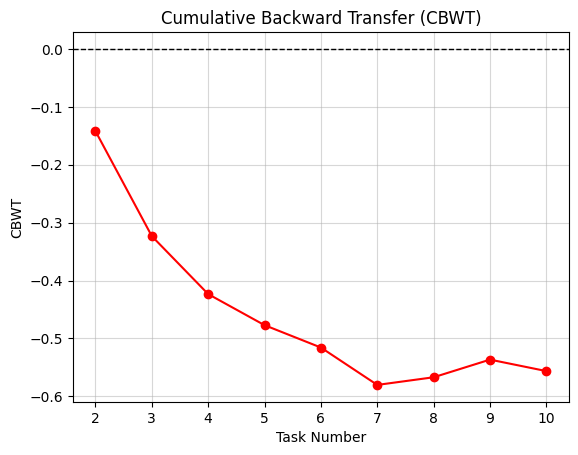

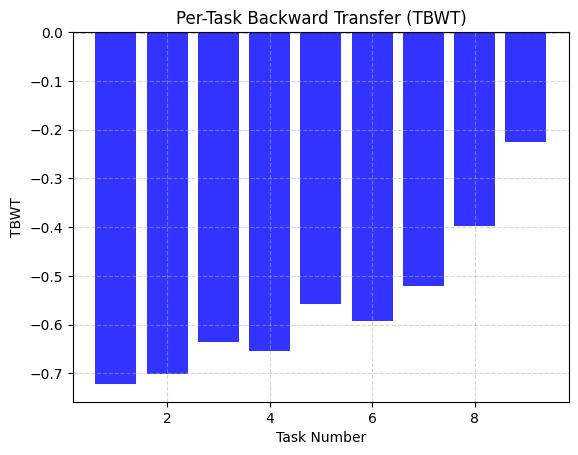

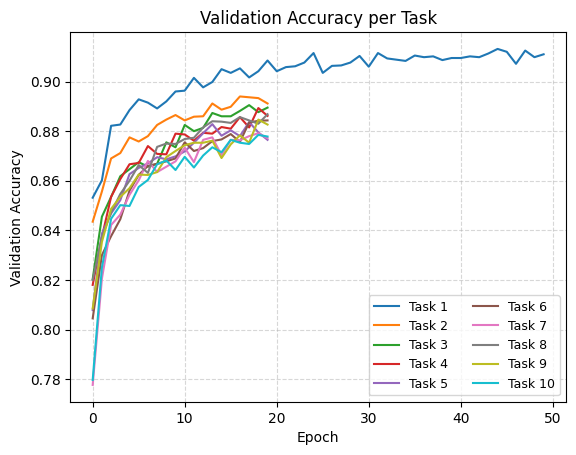

In [ ]:
# CBWT PLOT EX 
plt.plot(range(1, len(CBWT) + 1), CBWT, marker= "o", color = "red")
plt.title("Cumulative Backward Transfer (CBWT)")
plt.xlabel("Task Number")
plt.ylabel("CBWT")
plt.axhline(0, color="black", linestyle = "--", linewidth=1)
plt.grid(True, alpha=0.5)
plt.show()


# TBWT PLOT EX
plt.bar(range(1, len(TBWT) + 1), TBWT, color="blue", alpha=0.8)
plt.title("Per-Task Backward Transfer (TBWT)")
plt.xlabel("Task Number")
plt.ylabel("TBWT")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


# VALIDATION ACCURACY PLOT EX
for t, val_acc in enumerate(val_histories):
    plt.plot(val_acc, label=f"Task {t+1}")
plt.title("Validation Accuracy per Task")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend(ncol=2, fontsize=9)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [14]:
# Checking loss function

l1_results = run_experiment(
    depth = 2,                
    dropout_rate = 0.3, 
    loss_type = L1,
    optimizer_type = ADAM,
    learning_rate = 0.001,
    l1_lambda = 1e-5,
    l2_lambda = 1e-4,
    seed = 12345
)

l2_results = run_experiment(
    depth = 2,                
    dropout_rate = 0.3, 
    loss_type = L2,
    optimizer_type = ADAM,
    learning_rate = 0.001,
    l1_lambda = 1e-5,
    l2_lambda = 1e-4,
    seed = 12345
)

l1_l2_results = run_experiment(
    depth = 2,                
    dropout_rate = 0.3, 
    loss_type = L1_L2,
    optimizer_type = ADAM,
    learning_rate = 0.001,
    l1_lambda = 1e-5,
    l2_lambda = 1e-4,
    seed = 12345
)

nll_results = run_experiment(
    depth = 2,                
    dropout_rate = 0.3, 
    loss_type = NLL,
    optimizer_type = ADAM,
    learning_rate = 0.001,
    l1_lambda = 1e-5,
    l2_lambda = 1e-4,
    seed = 12345
)

Train Set:        (54000, 784), (54000,)
Validation Set:   (6000, 784) , (6000,)
Test Set:         (10000, 784), (10000,)
Training Task: 1 / 10
Epoch 1/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7898 - loss: 0.6945 - val_accuracy: 0.8663 - val_loss: 0.4943
Epoch 2/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8430 - loss: 0.5311 - val_accuracy: 0.8665 - val_loss: 0.4611
Epoch 3/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8584 - loss: 0.4859 - val_accuracy: 0.8745 - val_loss: 0.4359
Epoch 4/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8644 - loss: 0.4657 - val_accuracy: 0.8842 - val_loss: 0.4140
Epoch 5/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8700 - loss: 0.4507 - val_accuracy: 0.8813 - val_loss: 0.4204
Epoch 6/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8739 - loss: 0.4368 - val_accuracy: 0.8927 - val_loss: 0.3931
Epoch 7/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8756 - loss: 0.4292 - 

Loss Function |   ACC |   BWT
------------------------------
NLL        | 0.3325 |  -0.5965
L1         | 0.2190 |  -0.7307
L2         | 0.2310 |  -0.7179
L1 + L2    | 0.2190 |  -0.7278


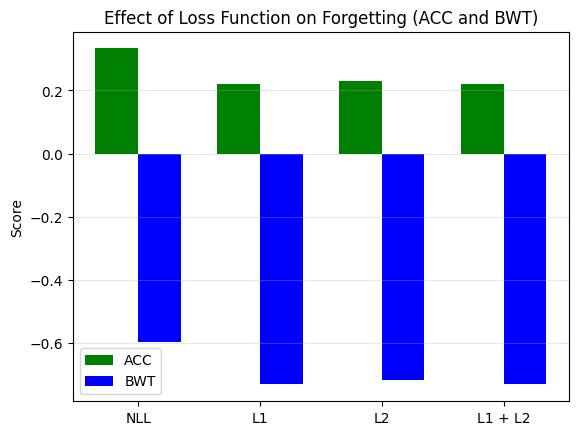

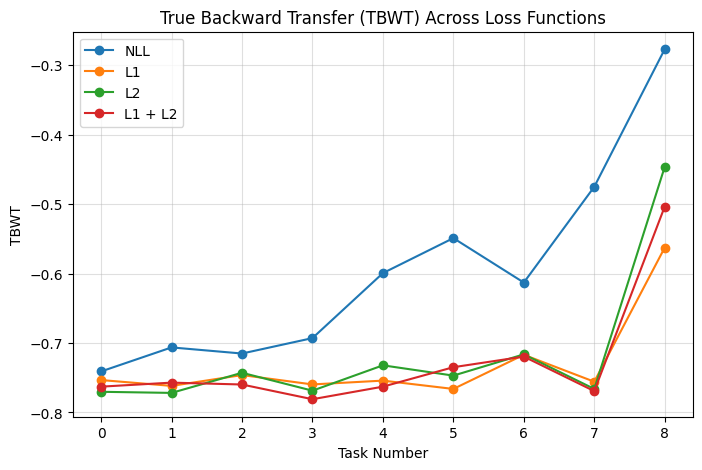

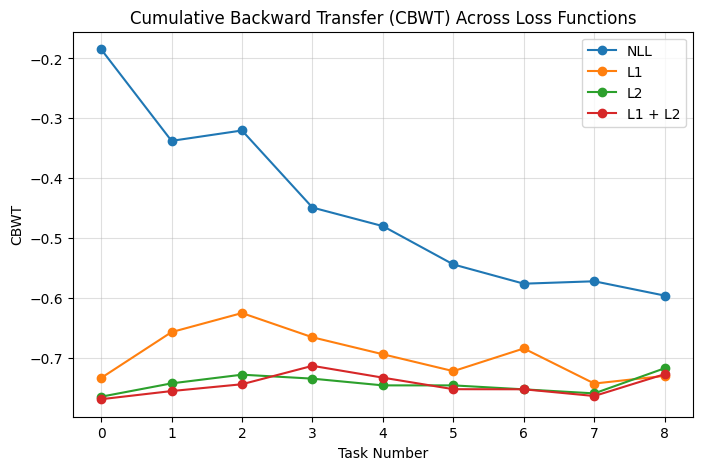

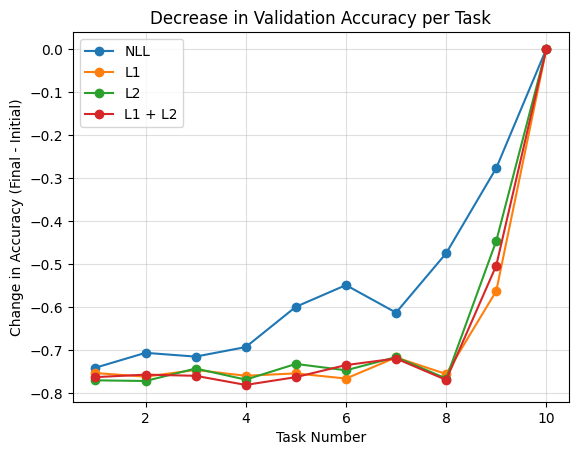

In [39]:
# loss function analysis

# indices for analysis
# 0. acc_matrix
# 1. ACC
# 2. BWT
# 3. TBWT
# 4. CBWT
# 5. val_histories

l1_results
l2_results
l1_l2_results
nll_results

loss_results = {
    "NLL": nll_results,
    "L1": l1_results,
    "L2": l2_results,
    "L1 + L2": l1_l2_results
}

# get the summary table
print(f'{"Loss Function":<11} | {"ACC":>5} | {"BWT":>5}')
print("-" * 30)
for k, v in loss_results.items():
    print(f"{k:<10} | {v[1]:>5.4f} | {v[2]:>8.4f}")

# get the metrics out of the data
labels = list(loss_results.keys())
accs  = [result[1] for result in loss_results.values()]
bwts  = [result[2] for result in loss_results.values()]

bar_width = 0.35
x = np.arange(len(labels))

plt.bar(x - bar_width/2, accs, width=bar_width, color="green", label = "ACC")
plt.bar(x + bar_width/2, bwts, width=bar_width, color="blue", label = "BWT")
plt.xticks(x, labels)
plt.title("Effect of Loss Function on Forgetting (ACC and BWT)")
plt.ylabel("Score")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()


# plot TBWT
plt.figure(figsize=(8, 5))
for label, res in loss_results.items():
    plt.plot(res[3], marker="o", label=label)
plt.title("True Backward Transfer (TBWT) Across Loss Functions")
plt.xlabel("Task Number")
plt.ylabel("TBWT")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()


# plot CBWT
plt.figure(figsize=(8, 5))
for label, res in loss_results.items():
    plt.plot(res[4], marker="o", label=label)
plt.title("Cumulative Backward Transfer (CBWT) Across Loss Functions")
plt.xlabel("Task Number")
plt.ylabel("CBWT")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()



# plot the decrease in validation accuracy per task
for label, res in loss_results.items():
    acc_matrix = res[0]
    num_tasks = acc_matrix.shape[0]
    forgetting_per_task = acc_matrix[-1, :] - np.diag(acc_matrix)

    plt.plot(
        np.arange(1, num_tasks + 1),
        forgetting_per_task,
        marker='o',
        label=label
    )

plt.title("Decrease in Validation Accuracy per Task")
plt.xlabel("Task Number")
plt.ylabel("Change in Accuracy (Final - Initial)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

In [15]:
# checking dropout

no_dropout_results = run_experiment(
    depth = 2,                
    dropout_rate = 0.0, 
    loss_type = NLL,
    optimizer_type = ADAM,
    learning_rate = 0.001,
    l1_lambda = 1e-5,
    l2_lambda = 1e-4,
    seed = 12345
)

med_dropout_results = run_experiment(
    depth = 2,                
    dropout_rate = 0.3, 
    loss_type = NLL,
    optimizer_type = ADAM,
    learning_rate = 0.001,
    l1_lambda = 1e-5,
    l2_lambda = 1e-4,
    seed = 12345
)

high_dropout_results = run_experiment(
    depth = 2,                
    dropout_rate = 0.5, 
    loss_type = NLL,
    optimizer_type = ADAM,
    learning_rate = 0.001,
    l1_lambda = 1e-5,
    l2_lambda = 1e-4,
    seed = 12345
)

Train Set:        (54000, 784), (54000,)
Validation Set:   (6000, 784) , (6000,)
Test Set:         (10000, 784), (10000,)
Training Task: 1 / 10
Epoch 1/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8216 - loss: 0.5007 - val_accuracy: 0.8635 - val_loss: 0.3840
Epoch 2/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8678 - loss: 0.3628 - val_accuracy: 0.8760 - val_loss: 0.3456
Epoch 3/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8824 - loss: 0.3229 - val_accuracy: 0.8825 - val_loss: 0.3234
Epoch 4/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8913 - loss: 0.2966 - val_accuracy: 0.8837 - val_loss: 0.3217
Epoch 5/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8983 - loss: 0.2768 - val_accuracy: 0.8855 - val_loss: 0.3270
Epoch 6/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9030 - loss: 0.2607 - val_accuracy: 0.8850 - val_loss: 0.3222
Epoch 7/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9089 - loss: 0.2467 - 

Dropout Rate         |     ACC |     BWT
----------------------------------------
No Dropout (0.0)     |  0.3006 | -0.6379
Medium Dropout (0.3) |  0.3183 | -0.6090
High Dropout (0.5)   |  0.3354 | -0.5524


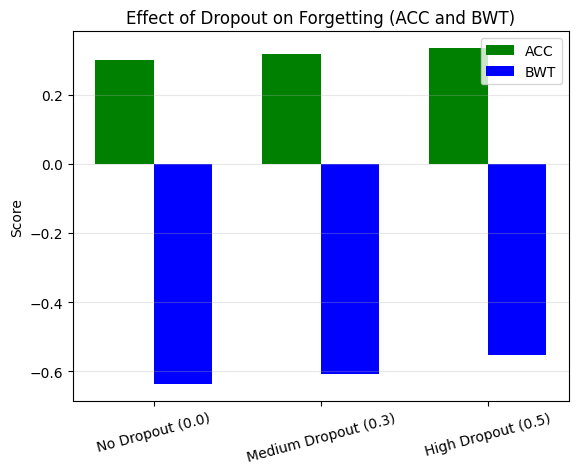

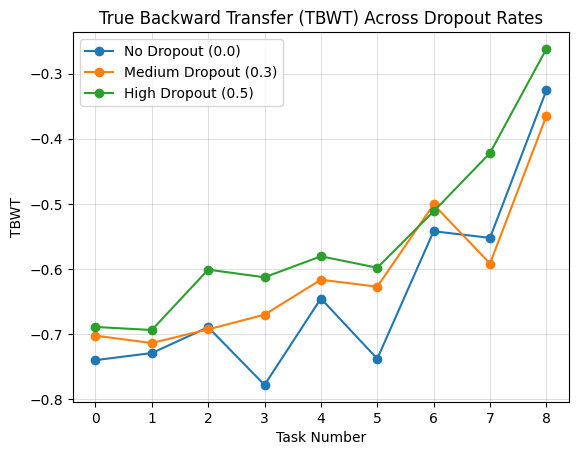

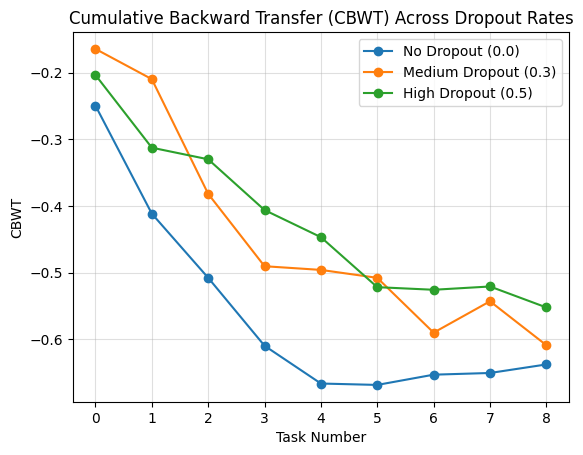

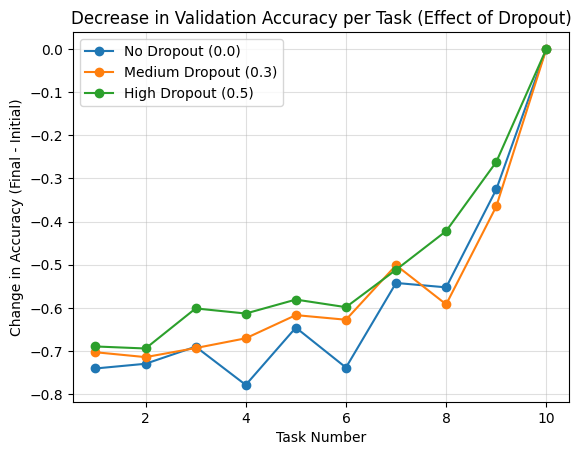

In [40]:
# dropout analysis

# indices for analysis
# 0. acc_matrix
# 1. ACC
# 2. BWT
# 3. TBWT
# 4. CBWT
# 5. val_histories

dropout_results = {
    "No Dropout (0.0)": no_dropout_results,
    "Medium Dropout (0.3)": med_dropout_results,
    "High Dropout (0.5)": high_dropout_results
}

# get the summary table
print(f'{"Dropout Rate":<20} | {"ACC":>7} | {"BWT":>7}')
print("-" * 40)
for k, v in dropout_results.items():
    print(f"{k:<20} | {v[1]:>7.4f} | {v[2]:>7.4f}")

# extract metrics
labels = list(dropout_results.keys())
accs  = [result[1] for result in dropout_results.values()]
bwts  = [result[2] for result in dropout_results.values()]

# plot ACC and BWT side-by-side
bar_width = 0.35
x = np.arange(len(labels))

plt.bar(x - bar_width/2, accs, width=bar_width, color="green", label="ACC")
plt.bar(x + bar_width/2, bwts, width=bar_width, color="blue", label="BWT")
plt.xticks(x, labels, rotation=15)
plt.title("Effect of Dropout on Forgetting (ACC and BWT)")
plt.ylabel("Score")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()


# plot TBWT
for label, res in dropout_results.items():
    plt.plot(res[3], marker="o", label=label)
plt.title("True Backward Transfer (TBWT) Across Dropout Rates")
plt.xlabel("Task Number")
plt.ylabel("TBWT")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()


# plot CBWT
for label, res in dropout_results.items():
    plt.plot(res[4], marker="o", label=label)
plt.title("Cumulative Backward Transfer (CBWT) Across Dropout Rates")
plt.xlabel("Task Number")
plt.ylabel("CBWT")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()


# plot the decrease in validation accuracy per task
for label, res in dropout_results.items():
    acc_matrix = res[0]
    num_tasks = acc_matrix.shape[0]
    forgetting_per_task = acc_matrix[-1, :] - np.diag(acc_matrix)

    plt.plot(
        np.arange(1, num_tasks + 1),
        forgetting_per_task,
        marker='o',
        label=label
    )

plt.title("Decrease in Validation Accuracy per Task (Effect of Dropout)")
plt.xlabel("Task Number")
plt.ylabel("Change in Accuracy (Final - Initial)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

In [ ]:
# checking model depth

small_depth_results = run_experiment(
    depth = 2,                
    dropout_rate = 0.3, 
    loss_type = NLL,
    optimizer_type = ADAM,
    learning_rate = 0.001,
    l1_lambda = 1e-5,
    l2_lambda = 1e-4,
    seed = 12345
)

med_depth_results = run_experiment(
    depth = 3,                
    dropout_rate = 0.3, 
    loss_type = NLL,
    optimizer_type = ADAM,
    learning_rate = 0.001,
    l1_lambda = 1e-5,
    l2_lambda = 1e-4,
    seed = 12345
)

high_depth_results = run_experiment(
    depth = 4,                
    dropout_rate = 0.3, 
    loss_type = NLL,
    optimizer_type = ADAM,
    learning_rate = 0.001,
    l1_lambda = 1e-5,
    l2_lambda = 1e-4,
    seed = 12345
)

Train Set:        (54000, 784), (54000,)
Validation Set:   (6000, 784) , (6000,)
Test Set:         (10000, 784), (10000,)
Training Task: 1 / 10
Epoch 1/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7883 - loss: 0.5909 - val_accuracy: 0.8628 - val_loss: 0.4050
Epoch 2/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8473 - loss: 0.4237 - val_accuracy: 0.8720 - val_loss: 0.3610
Epoch 3/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8575 - loss: 0.3880 - val_accuracy: 0.8853 - val_loss: 0.3285
Epoch 4/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8666 - loss: 0.3636 - val_accuracy: 0.8785 - val_loss: 0.3262
Epoch 5/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8703 - loss: 0.3486 - val_accuracy: 0.8822 - val_loss: 0.3190
Epoch 6/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8751 - loss: 0.3386 - val_accuracy: 0.8918 - val_loss: 0.3040
Epoch 7/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8801 - loss: 0.3251 - 

Network Depth   |     ACC |     BWT
----------------------------------------
2 Layers        |  0.3597 | -0.5663
3 Layers        |  0.3537 | -0.5670
4 Layers        |  0.3266 | -0.5784


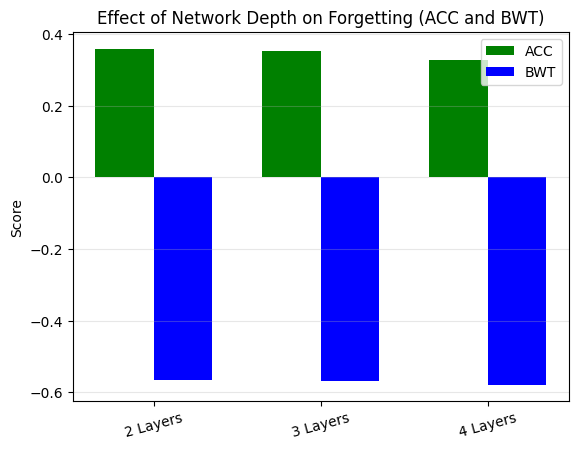

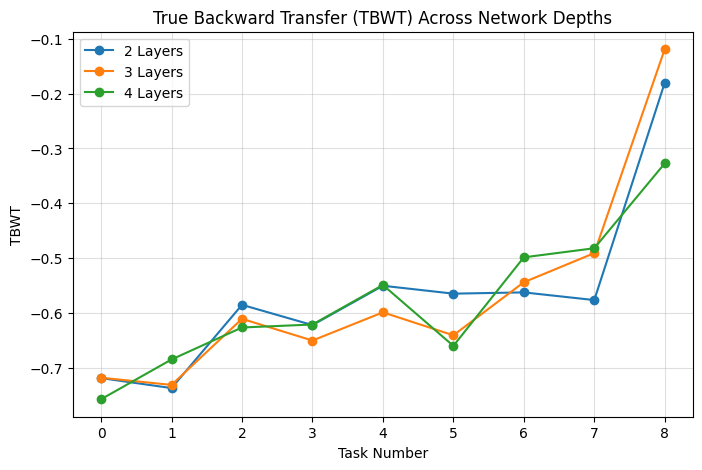

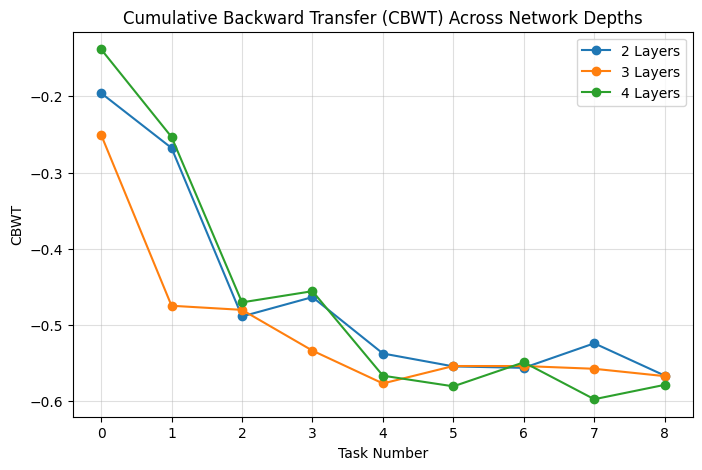

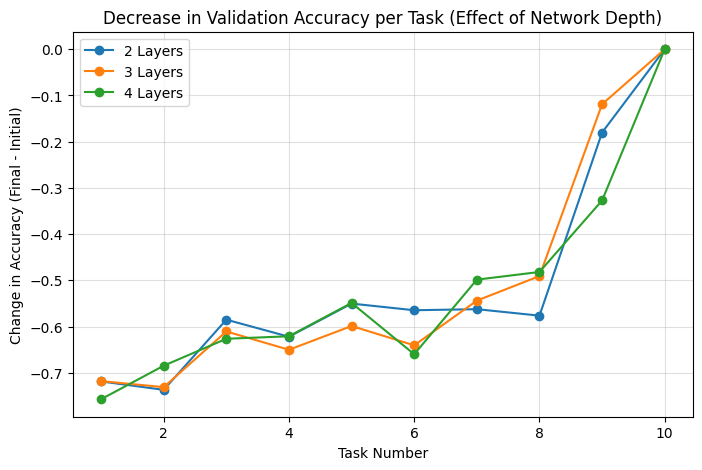

In [41]:
# model depth analysis

# indices for analysis
# 0. acc_matrix
# 1. ACC
# 2. BWT
# 3. TBWT
# 4. CBWT
# 5. val_histories

depth_results = {
    "2 Layers": small_depth_results,
    "3 Layers": med_depth_results,
    "4 Layers": high_depth_results
}

# get the summary table
print(f'{"Network Depth":<15} | {"ACC":>7} | {"BWT":>7}')
print("-" * 40)
for k, v in depth_results.items():
    print(f"{k:<15} | {v[1]:>7.4f} | {v[2]:>7.4f}")

# extract metrics
labels = list(depth_results.keys())
accs  = [result[1] for result in depth_results.values()]
bwts  = [result[2] for result in depth_results.values()]

# plot ACC and BWT side-by-side
bar_width = 0.35
x = np.arange(len(labels))

plt.bar(x - bar_width/2, accs, width=bar_width, color="green", label="ACC")
plt.bar(x + bar_width/2, bwts, width=bar_width, color="blue", label="BWT")
plt.xticks(x, labels, rotation=15)
plt.title("Effect of Network Depth on Forgetting (ACC and BWT)")
plt.ylabel("Score")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()


# plot TBWT
plt.figure(figsize=(8, 5))
for label, res in depth_results.items():
    plt.plot(res[3], marker="o", label=label)
plt.title("True Backward Transfer (TBWT) Across Network Depths")
plt.xlabel("Task Number")
plt.ylabel("TBWT")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()


# plot CBWT
plt.figure(figsize=(8, 5))
for label, res in depth_results.items():
    plt.plot(res[4], marker="o", label=label)
plt.title("Cumulative Backward Transfer (CBWT) Across Network Depths")
plt.xlabel("Task Number")
plt.ylabel("CBWT")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()


# plot the decrease in validation accuracy per task
plt.figure(figsize=(8, 5))
for label, res in depth_results.items():
    acc_matrix = res[0]
    num_tasks = acc_matrix.shape[0]
    forgetting_per_task = acc_matrix[-1, :] - np.diag(acc_matrix)

    plt.plot(
        np.arange(1, num_tasks + 1),
        forgetting_per_task,
        marker='o',
        label=label
    )

plt.title("Decrease in Validation Accuracy per Task (Effect of Network Depth)")
plt.xlabel("Task Number")
plt.ylabel("Change in Accuracy (Final - Initial)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

In [17]:
# checking different optimizers

adam_results = run_experiment(
    depth = 2,                
    dropout_rate = 0.3, 
    loss_type = NLL,
    optimizer_type = ADAM,
    learning_rate = 0.001,
    l1_lambda = 1e-5,
    l2_lambda = 1e-4,
    seed = 12345
)

sgd_results = run_experiment(
    depth = 2,                
    dropout_rate = 0.3, 
    loss_type = NLL,
    optimizer_type = SGD,
    learning_rate = 0.001,
    l1_lambda = 1e-5,
    l2_lambda = 1e-4,
    seed = 12345
)

rmsprop_results = run_experiment(
    depth = 2,                
    dropout_rate = 0.3, 
    loss_type = NLL,
    optimizer_type = RMSPROP,
    learning_rate = 0.001,
    l1_lambda = 1e-5,
    l2_lambda = 1e-4,
    seed = 12345
)

Train Set:        (54000, 784), (54000,)
Validation Set:   (6000, 784) , (6000,)
Test Set:         (10000, 784), (10000,)
Training Task: 1 / 10
Epoch 1/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7895 - loss: 0.5904 - val_accuracy: 0.8468 - val_loss: 0.4151
Epoch 2/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8459 - loss: 0.4261 - val_accuracy: 0.8682 - val_loss: 0.3604
Epoch 3/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8579 - loss: 0.3910 - val_accuracy: 0.8805 - val_loss: 0.3361
Epoch 4/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8646 - loss: 0.3680 - val_accuracy: 0.8865 - val_loss: 0.3214
Epoch 5/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8711 - loss: 0.3514 - val_accuracy: 0.8837 - val_loss: 0.3160
Epoch 6/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8774 - loss: 0.3361 - val_accuracy: 0.8885 - val_loss: 0.3091
Epoch 7/50
540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8793 - loss: 0.3257 - 

Optimizer  |     ACC |     BWT
------------------------------
Adam       |  0.3418 | -0.5879
SGD        |  0.7024 | -0.1180
RMSProp    |  0.3248 | -0.5944


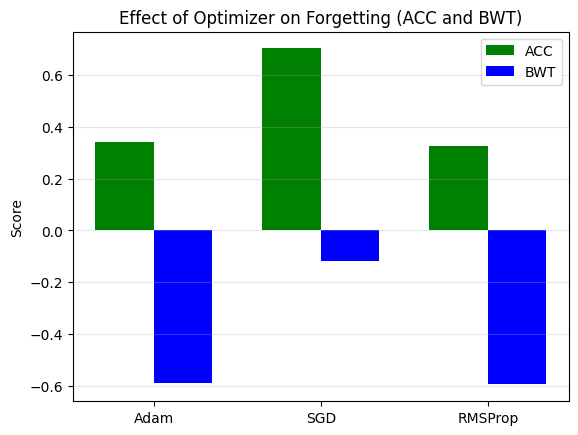

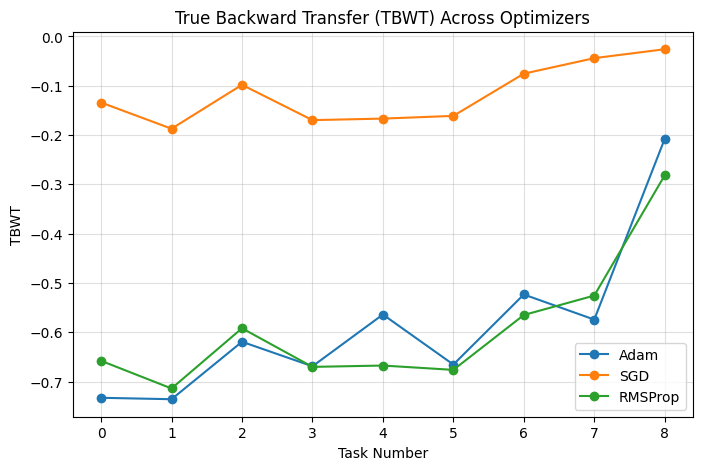

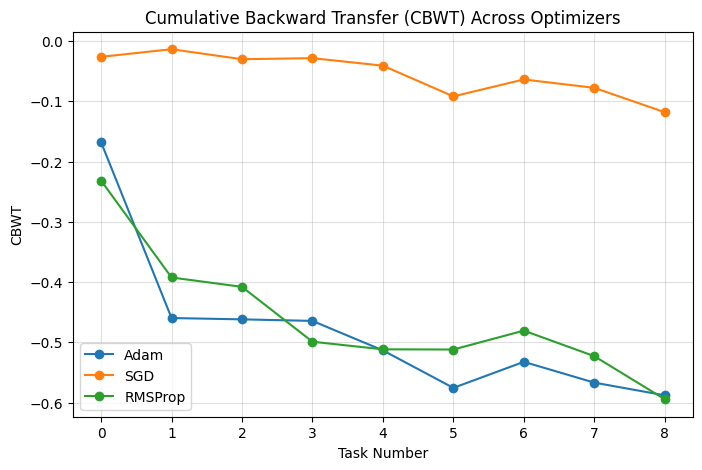

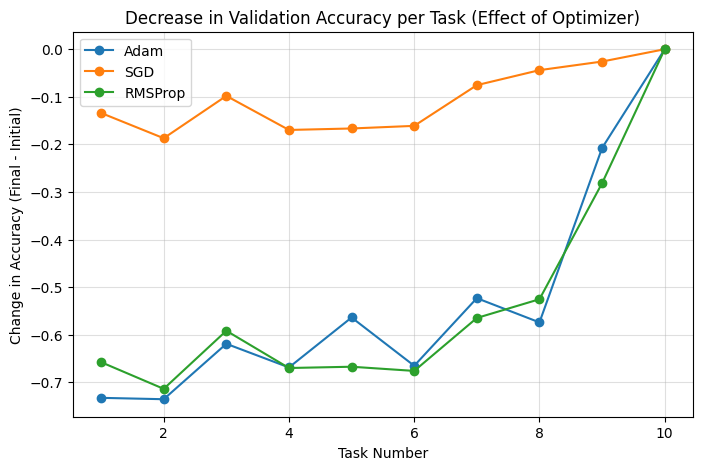

In [42]:
# optimizer analysis

# indices for analysis
# 0. acc_matrix
# 1. ACC
# 2. BWT
# 3. TBWT
# 4. CBWT
# 5. val_histories

optimizer_results = {
    "Adam": adam_results,
    "SGD": sgd_results,
    "RMSProp": rmsprop_results
}

# get the summary table
print(f'{"Optimizer":<10} | {"ACC":>7} | {"BWT":>7}')
print("-" * 30)
for k, v in optimizer_results.items():
    print(f"{k:<10} | {v[1]:>7.4f} | {v[2]:>7.4f}")

# extract metrics
labels = list(optimizer_results.keys())
accs  = [result[1] for result in optimizer_results.values()]
bwts  = [result[2] for result in optimizer_results.values()]

# plot ACC and BWT side-by-side
bar_width = 0.35
x = np.arange(len(labels))

plt.bar(x - bar_width/2, accs, width=bar_width, color="green", label="ACC")
plt.bar(x + bar_width/2, bwts, width=bar_width, color="blue", label="BWT")
plt.xticks(x, labels)
plt.title("Effect of Optimizer on Forgetting (ACC and BWT)")
plt.ylabel("Score")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()


# plot TBWT
plt.figure(figsize=(8, 5))
for label, res in optimizer_results.items():
    plt.plot(res[3], marker="o", label=label)
plt.title("True Backward Transfer (TBWT) Across Optimizers")
plt.xlabel("Task Number")
plt.ylabel("TBWT")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()


# plot CBWT
plt.figure(figsize=(8, 5))
for label, res in optimizer_results.items():
    plt.plot(res[4], marker="o", label=label)
plt.title("Cumulative Backward Transfer (CBWT) Across Optimizers")
plt.xlabel("Task Number")
plt.ylabel("CBWT")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()


# plot the decrease in validation accuracy per task
plt.figure(figsize=(8, 5))
for label, res in optimizer_results.items():
    acc_matrix = res[0]
    num_tasks = acc_matrix.shape[0]
    forgetting_per_task = acc_matrix[-1, :] - np.diag(acc_matrix)

    plt.plot(
        np.arange(1, num_tasks + 1),
        forgetting_per_task,
        marker='o',
        label=label
    )

plt.title("Decrease in Validation Accuracy per Task (Effect of Optimizer)")
plt.xlabel("Task Number")
plt.ylabel("Change in Accuracy (Final - Initial)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()